In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split

In [4]:
# Use this sigmoid function to turn probabilities into classifications
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

A simple synthetic dataset is created below. It has a 1D normal distribution, the goal is to predict Class '1' if the item is positive and '0' otherwise.

In [8]:
# Generate an array of 5000 random numbers that are normally distributed
X_all = np.random.randn(5000, 1)

Based on whether the item is greater or less than zero, the mask will return true or false. The result is multiplied by 2 and 1 is subtracted to convert booleans into 1 or 0

In [9]:
y_all = (X_all[:, 0] > 0)*2 - 1

Use sci-kit learn's famous [train-test-split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Half the data is used for training data and the remaining hald if used for testing purposes.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=42)

You will notice this dataset can be solved with one tree stump! Thus, we will choose max depth as 1

In [11]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)

print ('Accuracy for a single decision stump: {}'.format(clf.score(X_test, y_test)))

Accuracy for a single decision stump: 1.0


The Decision Tree Classifier only needed 1 stump but for the Gradient Boosting Classifier, we will need 800 trees to classify the data correctly. We shall use sklearn's GradientBoostingClassifier

In [12]:
clf = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.01, max_depth=3, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [15]:
print('Accuracy for Gradient Booing: {}'.format(clf.score(X_test, y_test)))

Accuracy for Gradient Booing: 1.0


The predict_proba method gives the probabilities on a data-point belonging to a class. As our metric, we will use the logloss method from sklearn. Find more about it [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

In [17]:
y_pred = clf.predict_proba(X_test)[:, 1]
print("Test logloss: {}".format(log_loss(y_test, y_pred)))

Test logloss: 0.00031395706515999623


Some helper functions below

In [18]:
def compute_loss(y_true, scores_pred):
    '''
        Since we use raw scores we will wrap log_loss 
        and apply sigmoid to our predictions before computing log_loss itself
    '''
    return log_loss(y_true, sigmoid(scores_pred))
    

'''
    Get cummulative sum of *decision function* for trees. i-th element is a sum of trees 0...i-1.
    We cannot use staged_predict_proba, since we want to manipulate raw scores
    (not probabilities). And only in the end convert the scores to probabilities using sigmoid
'''
cum_preds = np.array([x for x in clf.staged_decision_function(X_test)])[:, :, 0] 

print ("Logloss using all trees:           {}".format(compute_loss(y_test, cum_preds[-1, :])))
print ("Logloss using all trees but last:  {}".format(compute_loss(y_test, cum_preds[-2, :])))
print ("Logloss using all trees but first: {}".format(compute_loss(y_test, cum_preds[-1, :] - cum_preds[0, :])))

Logloss using all trees:           0.00031395706515999623
Logloss using all trees but last:  0.00031395706515999623
Logloss using all trees but first: 0.0003201645012256856


While there is a LogLoss difference, it is not as significant as you would expect. If you get rid of the first tree, the model still works! Let's take a plot of the cummulative decision function depending on the number of trees to understand this further

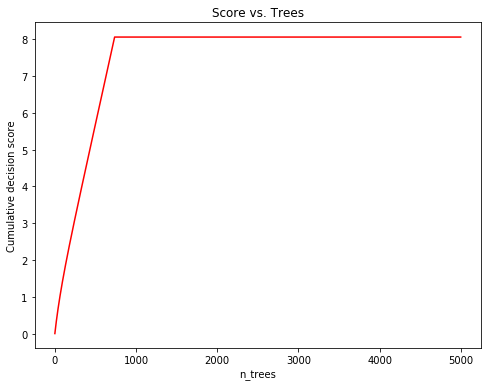

In [24]:
# Pick an object of class 1 for visualisation
plt.figure(figsize=(8, 6))
plt.plot(cum_preds[:, y_test == 1][:, 0], color='r')

plt.xlabel('n_trees')
plt.ylabel('Cumulative decision score')
plt.title('Score vs. Trees')
plt.savefig('plots/score_vs_trees.png', transparent=False)
plt.show()

You can notice that the decision function improves ~ linearly till about the 800 iteration and then stops. This is actually connected to the learning rate of 0.01 which we set! 

The main formula of boosting is:
    $$ F(x) = const + \sum\limits_{i=1}^{n}\gamma_i h_i(x) $$

In our case, $\gamma_i$ are constant and equal to learning rate $\eta = 0.01$. It takes about $800$ iterations to get the score $8$, which means at every iteration score goes up for about $0.01$. It means that first 800 terms are approximately equal to $0.01$, and the following are almost $0$. 

So if we drop the last tree, we lower $F(x)$ by $0$ and if we drop the first tree we lower $F(x)$ by $0.01$, which results in a very very little performance drop!

So, even in the case of simple dataset which can be solved with single decision stump, with a Gradient Boosting Machine we need to sum a lot of trees (roughly $\frac{1}{\eta}$) to approximate this golden single decision stump.

**What if we use a larger learning rate?** Let's use the learning rate of 10

In [27]:
clf = GradientBoostingClassifier(n_estimators=5000, learning_rate=10, max_depth=3, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=10, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
y_pred = clf.predict_proba(X_test)[:, 1]
print("Test logloss: {}".format(log_loss(y_test, y_pred)))

Test logloss: 1.576775527753681e-07


In [30]:
print('Accuracy for High Learning Rate GBM: {}'.format(clf.score(X_test, y_test)))

Accuracy for High Learning Rate GBM: 1.0


In [31]:
cum_preds = np.array([x for x in clf.staged_decision_function(X_test)])[:, :, 0] 

print ("Logloss using all trees:           {}".format(compute_loss(y_test, cum_preds[-1, :])))
print ("Logloss using all trees but last:  {}".format(compute_loss(y_test, cum_preds[-2, :])))
print ("Logloss using all trees but first: {}".format(compute_loss(y_test, cum_preds[-1, :] - cum_preds[0, :])))

Logloss using all trees:           1.576775527753681e-07
Logloss using all trees but last:  1.477019511879915e-07
Logloss using all trees but first: 2.6510054774492775


As you can see, the significance of the first tree in a GBM is clear. The logloss without the first tree is much higher! Let's plot the score vs. trees like we did earlier

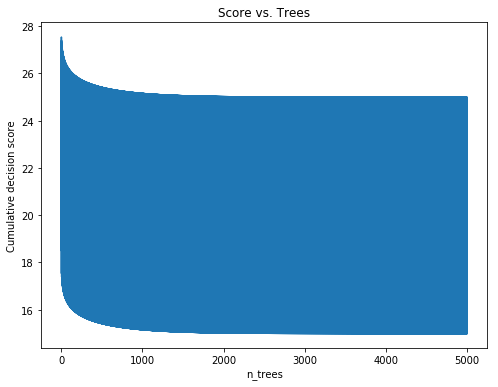

In [44]:
# Pick an object of class 1 for visualisation
plt.figure(figsize=(8, 6))
plt.plot(cum_preds[:, y_test == 1][:, 0])

plt.xlabel('n_trees')
plt.ylabel('Cumulative decision score')
plt.title('Score vs. Trees')
plt.savefig('plots/score_vs_trees_high_learn.png', transparent=False)
plt.show()

In [41]:
from xgboost import XGBClassifier

In [42]:
xg_model = XGBClassifier(n_estimators=5000, learning_rate=0.01)
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
print('Accuracy for XGBoost: {}'.format(xg_model.score(X_train, y_train)))

Accuracy for XGBoost: 1.0
